In [1]:
import sys
import jax.numpy as jnp
import jax
import time
import matplotlib.pyplot as plt
import random
import os
import json
import stim
import chex
from flax import struct
from typing import Tuple, Optional
from inspect import signature
from jax import lax
from functools import partial
from jax import jit
from matplotlib import rc
# rc('text', usetex=True)
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)
plt.rcParams.update({'font.size': 24})
# plt.rcParams.update({"pgf.texsystem": "pdflatex"})
plt.rcParams.update({'figure.dpi': 150})

%load_ext autoreload
%autoreload 2
%matplotlib inline

# os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

In [2]:
@struct.dataclass
class EnvState:
    """
    This class contains the code generators of the quantum circuit:

    G_X: binary array of size n_qubits_physical*(num_H)
    G_X: binary array of size n_qubits_physical*(n_qubits_physical - n_qubits_logical - num_H)
    """
    G_X: jnp.array
    G_Z: jnp.array

In [3]:
@jit
def step(key: chex.PRNGKey, state: EnvState, action: int) -> EnvState:
    """Performs step transitions in the environment."""
    
    x_label = action
    z_label = action + z_action_move[action]
    
    # Update state
    state = EnvState( (state.G_X @ actions[x_label]) % 2, (state.G_Z @ actions[z_label]) % 2)

    return lax.stop_gradient(state)

In [4]:
def action_matrix(gates, n_qubits_physical, graph) -> chex.Array:
        
    action_matrix = []
    z_action_move = []

    for gate in gates:
        ## One qubit gate
        if len(signature(gate).parameters) == 1:
            for n_qubit in range(n_qubits_physical):                    
                action_matrix.append(gate(n_qubit))     

        ## Two qubit gates
        elif len(signature(gate).parameters) == 2:
            for edge in graph:
                action_matrix.append(gate(edge[0], edge[1]))                    
                if edge[0] < edge[1]:
                    z_action_move.append(1)
                else:
                    z_action_move.append(-1)
                
    return jnp.array(action_matrix, dtype=jnp.uint8), jnp.array(z_action_move, dtype=jnp.int8)

In [5]:
### - CHANGE FOR DIFFERENT NUMBER OF QUBITS - 
n_qubits_physical = 7*7
n_qubits_logical = 0
### ----------------

init_H = [n_qubits_logical+2*i for i in range((n_qubits_physical-n_qubits_logical)//2)]

print(n_qubits_physical)

graph = []
# Nearest neighbor
for ii in range(n_qubits_physical-1):
    graph.append((ii,ii+1))
    graph.append((ii+1,ii))

49


In [6]:
from simulators.clifford_gates_css import CliffordGatesCSS

gates = CliffordGatesCSS(n_qubits_physical)
        
gate_set = []
for g in ['cx']:
    gate_set.append(eval("gates.%s" % g))

In [7]:
actions, z_action_move = action_matrix(gate_set, n_qubits_physical, graph)

In [8]:
from simulators.tableau_simulator_css import TableauSimulatorCSS

@jit
def reset(reset_rng):

    tableau = TableauSimulatorCSS(n_qubits_physical, n_qubits_logical, init_H, bell=False)

    state = EnvState(
        G_X = tableau.H_X,
        G_Z = tableau.H_Z
    )
   
    return state

In [42]:
# COLLECT TRAJECTORIES
@jit
def _env_step(runner_state, unused):

    env_state, rng = runner_state

    # SELECT ACTION
    rng, _rng = jax.random.split(rng)
    action = jax.random.choice(_rng, jnp.arange(len(actions)), shape=(num_envs,))

    # STEP ENV
    rng, _rng = jax.random.split(rng)
    rng_step = jax.random.split(_rng, num_envs)

    env_state = jax.vmap(step, in_axes=(0,0,0))(rng_step, env_state, action)

    runner_state = (env_state, rng)
    return runner_state, None


# INIT ENV

# - CHANGE FOR DIFFERENT NUMBER OF CIRCUITS IN PARALLEL -
num_envs = 1024*2*2*2*2
# --------
rng = jax.random.PRNGKey(42)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_envs)
env_state = jax.vmap(reset, in_axes=(0))(reset_rng)

runner_state = (env_state, rng)


In [43]:
%%timeit
# INIT ENV
rng = jax.random.PRNGKey(42)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_envs)
env_state = jax.vmap(reset, in_axes=(0))(reset_rng)

runner_state = (env_state, rng)

# - CHANGE FOR DIFFERENT NUMBER OF GATES PER CIRCUIT -
num_steps = int(1e3)
# ------------------


runner_state, traj_batch = jax.block_until_ready(jax.lax.scan(
    _env_step, runner_state, None, num_steps)
)

2.98 s ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# CSS RESULTS
# in ms

# 49 qubits, 0 logicals, init_H alternating
# num_envs: 2**x

# 1000 gates
[74.6, 80.5, 49.1, 54, 55.2, 53.9, 54, 58.9, 80.9, 115, 203, 380, 746, 1480, 2980]

## Stim

In [44]:
def action_names(gates, n_qubits_physical, graph):
        
    action_string_stim = []

    for gate in gates:
        ## One qubit gate
        if len(signature(gate).parameters) == 1:
            for n_qubit in range(n_qubits_physical):                    
                action_string_stim.append('.%s(%d)' % (gate.__name__.lower(), n_qubit))
                
        ## Two qubit gates
        elif len(signature(gate).parameters) == 2:
            for edge in graph:
                action_string_stim.append('.%s(%d, %d)' % (gate.__name__.lower(), edge[0], edge[1]))

                
    return action_string_stim

In [46]:
%%timeit
# - USE SAME NUMBER OF GATES FOR FAIR COMPARISON
num_steps = int(1e3)
# ------------------
action_string_stim = action_names(gate_set, n_qubits_physical, graph)
actions = jax.random.choice(_rng, jnp.arange(len(action_string_stim)), shape=(num_steps,))
gates = ['.h(%d)' % i for i in init_H]+[action_string_stim[action] for action in actions]

circ = stim.Circuit()
for g in gates:
    gate_name = g.split("(")[0].split(".")[1]
    qubit_ids = g.split("(")[1].split(")")[0]
    eval("circ.append('%s', [%s])" % (gate_name, qubit_ids))

83.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Data and plots (CSS)

In [47]:
# 49 qubits
# 1000 gates per circuit
# stim: single random circuit
# ours: keep doubling batch size

stim_result = 83.5 # (in ms) \pm 1 ms
our_results = [74.6, 80.5, 49.1, 54, 55.2, 53.9, 54, 58.9, 80.9, 115, 203, 380, 746, 1480, 2980]
batch_size = 2**jnp.array(range(0, len(our_results)))

### Speedup

In [58]:
jnp.array([2**i*stim_result for i in range(len(batch_size))]) / jnp.array(our_results)

Array([  1.119303 ,   2.0745342,   6.8024445,  12.370371 ,  24.202898 ,
        49.573284 ,  98.96297  , 181.4601   , 264.22742  , 371.7565   ,
       421.20197  , 450.02106  , 458.4665   , 462.1838   , 459.0819   ],      dtype=float32)

### Plots

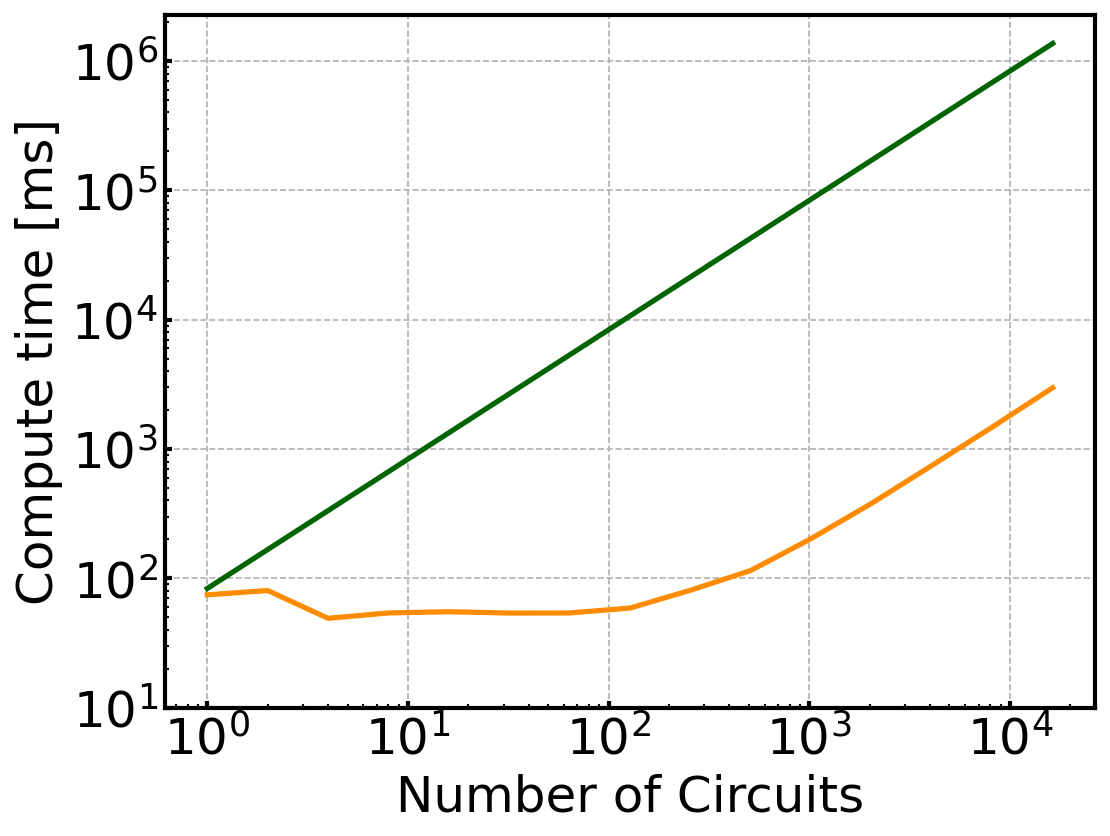

In [57]:
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FixedLocator, NullFormatter

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.loglog(batch_size, [2**i*stim_result for i in range(len(batch_size))], color='darkgreen', lw=2.5)
ax1.loglog(batch_size, our_results, color='darkorange', lw=2.5)
ax1.set_xlabel('Number of Circuits')
ax1.set_ylabel('Compute time [ms]')

# Customize the frame thickness
ax1.spines['top'].set_linewidth(2)     # Top frame
ax1.spines['right'].set_linewidth(2)   # Right frame
ax1.spines['bottom'].set_linewidth(2)  # Bottom frame
ax1.spines['left'].set_linewidth(2)    # Left frame

# Make the ticks point inside
ax1.tick_params(axis='both', direction='in', width=2)

# Display minor ticks on all boundaries of the frame
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(axis='both', which='minor', direction='in', width=1)  # Customize minor tick appearance


# plt.ylim([1e-7,1e-1])


ax1.xaxis.set_major_locator(LogLocator(base=10))
ax1.xaxis.set_minor_locator(LogLocator(base=10,subs=[1,2,3,4,5,6,7,8,9]))

ax1.yaxis.set_major_locator(LogLocator(base=10))
# ax1.yaxis.set_minor_locator(LogLocator(base=10,subs=[1,2,3,4,5,6,7,8,9]))
# ax1.yaxis.set_minor_locator(LogLocator(base=10, subs='all'))

plt.grid(True, linestyle='--')
plt.gca().set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
minor_ticks = [2e1,3e1,4e1,5e1,6e1,7e1,8e1,9e1,
               2e2,3e2,4e2,5e2,6e2,7e2,8e2,9e2,
               2e3,3e3,4e3,5e3,6e3,7e3,8e3,9e3,
              2e4,3e4,4e4,5e4,6e4,7e4,8e4,9e4,
              2e5,3e5,4e5,5e5,6e5,7e5,8e5,9e5,
              2e6,3e6,4e6,5e6,6e6,7e6,8e6,9e6]  # You can add as many as you want here

# Set minor ticks using FixedLocator
plt.gca().yaxis.set_minor_locator(FixedLocator(minor_ticks))
plt.gca().yaxis.set_minor_formatter(NullFormatter())

plt.show()


In [59]:
fig.savefig("ours_vs_stim.pdf")